<a href="https://colab.research.google.com/github/vaneesa-writes/micro_project/blob/main/real_vs_fake_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                         Diabetes Dataset                                      9KB  2022-10-06 08:55:25           2849         86  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset           COVID -19 Coronavirus Pandemic Dataset               11KB  2022-09-30 04:05:11           2448         70  1.0              
evangower/premier-league-matches-19922022                     Premier League Matches 1992-2022                     78KB  2022-10-03 02:18:33           1057         43  1.0              
whenamancodes/student-performance   

In [5]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

 99% 3.73G/3.75G [01:26<00:00, 25.5MB/s]
100% 3.75G/3.75G [01:26<00:00, 46.7MB/s]


In [ ]:
# import zipfile
# zf = "/content/tuberculosis-tb-chest-xray-dataset.zip"
# target_dir = "/content/dataset/cnn/chest-xray"
# zfile = zipfile.ZipFile(zf)
# zfile.extractall(target_dir)

In [6]:
!unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [7]:
!pip install torch_summary torch_snippets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 706 kB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 237 kB 63.0 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 1.6 MB 50.5 MB/s 
     |████████████████████████████████| 175 kB 75.1 MB/s 
     |████████████████████████████████| 2.2 MB 57.8 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=727445bf80df925d2fd1fb69ac87c43f2fec8f629cf45f66f7f442fb2e62c8a3
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=24c2fcc6772c4654e11ddcce0ca5c7cda1d028261176598a5186c9073beee4ff
  Stored in directory: /root/.cac

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torch_snippets import inspect, Report

import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint
import numpy as np
import cv2
from glob import glob
import pandas as pd

In [2]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mkdir: cannot create directory ‘saved_model’: File exists


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
DIR = 'content/'
train_df = pd.read_csv('/content/train.csv', index_col=0)
valid_df = pd.read_csv('/content/valid.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)
train_df.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


<BarContainer object of 2 artists>

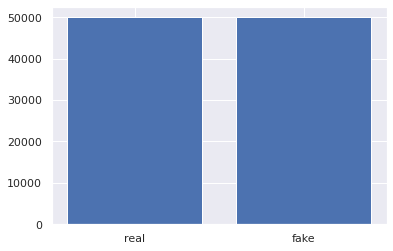

In [5]:
train_label = train_df['label_str'].value_counts()
plt.bar(train_label.index, train_label.values)

In [6]:
class FaceDataset(Dataset):
    def __init__(self, df, DIR="/content/real_vs_fake/real-vs-fake/"):
        super().__init__()
        self.df = df
        self.DIR = DIR
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        img_path = self.DIR + row['path']
        img = Image.open(img_path).convert('RGB')
        target = row['label']
        return img, target
    
    def choose(self):
        return self[randint(0, len(self)-1)]
    
    def decode(self, target):
        return ['fake', 'real'][target]
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        imgs = torch.stack(
            [self.transform(img) for img in imgs], 0
        )
        return imgs.to(device), targets.to(device)

In [7]:
train_ds = FaceDataset(train_df.sample(25000))
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)
valid_ds = FaceDataset(valid_df.sample(2000))
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=True,
                      collate_fn=valid_ds.collate_fn, 
                      drop_last=True)
test_ds = FaceDataset(test_df.sample(2000))
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True,
                      collate_fn=test_ds.collate_fn, 
                      drop_last=True)

In [8]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))
print('Size of Test:', len(test_ds))

Size of Train: 25000
Size of Validation: 2000
Size of Test: 2000


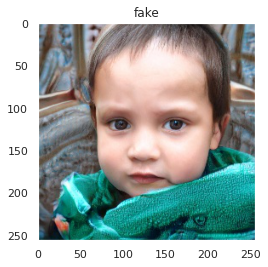

In [9]:
img, target = train_ds.choose()
label = train_ds.decode(target)

plt.grid(False)
plt.imshow(img)
plt.title(label)
plt.show()

In [10]:
inspect(*next(iter(train_dl)), names='image, target')

══════════════════════════════════════════════════════════════════

IMAGE:
Tensor  Shape: torch.Size([128, 3, 224, 224])   Min: -2.118     Max: 2.640      Mean: -0.033    dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

TARGET:
Tensor  Shape: torch.Size([128, 1])     Min: 0.000      Max: 1.000      Mean: 0.500     dtype: torch.float32 @ 
cuda:0

══════════════════════════════════════════════════════════════════

In [11]:
class FaceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True, progress=True)
        for param in self.backbone.parameters():
            param.requires_grad = True
        
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, 1)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [12]:
classifier = FaceClassifier()
_ = summary(classifier, torch.ones(32,3,299,299).to(device))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 150, 150]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 150, 150]        128
|    └─ReLU: 2-3                         [-1, 64, 150, 150]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 75, 75]          --
|    └─Sequential: 2-5                   [-1, 256, 75, 75]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 75, 75]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 75, 75]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 75, 75]         70,400
|    └─Sequential: 2-6                   [-1, 512, 38, 38]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 38, 38]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 38, 38]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 38, 38] 

In [13]:
sigmoid = nn.Sigmoid()

def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs)
    outputs = sigmoid(outputs)
    loss = loss_fn(outputs, targets)
    acc = sum((outputs > 0.5) == targets) / len(targets)
    classifier.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, acc

In [14]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    outputs = sigmoid(outputs)
    loss = loss_fn(outputs, targets)
    acc = sum((outputs > 0.5) == targets) / len(targets)
    return loss, acc

In [15]:
@torch.no_grad()
def test(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    outputs = sigmoid(outputs)
    loss = loss_fn(outputs, targets)
    acc = sum((outputs > 0.5) == targets) / len(targets)
    return loss, acc

In [16]:
n_epochs = 20
log = Report(n_epochs)
classifier = FaceClassifier().to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                     gamma=0.5)
best_acc = 0

In [21]:
for epoch in range(n_epochs):
    n_batch = len(train_dl)
    for i, data in enumerate(train_dl):
        train_loss, train_acc = train(data, classifier,
                                      optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, train_loss=train_loss,
                   train_acc=train_acc, end='\r')
    
    n_batch = len(valid_dl)
    accs = []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_acc = validate(data, classifier, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, valid_loss=valid_loss,
                   valid_acc=valid_acc, end='\r')
        accs.append(float(valid_acc.cpu().detach()))
    
    cur_acc = np.mean(accs)
    if best_acc < cur_acc:
        best_acc = cur_acc
        torch.save(classifier.state_dict(), './saved_model/resnet50_whole_classifier_weights.pth')
        
    scheduler.step()

EPOCH: 20.000  valid_loss: 0.104  valid_acc: 0.961  (7079.74s - 0.00s remaining)

100%|██████████| 121/121 [00:00<00:00, 300.97it/s]


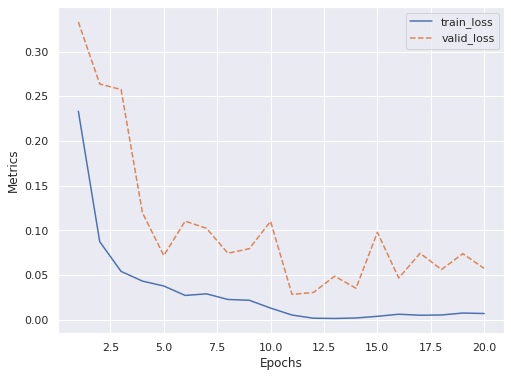

In [22]:
log.plot_epochs(['train_loss', 'valid_loss'])

100%|██████████| 121/121 [00:00<00:00, 488.68it/s]


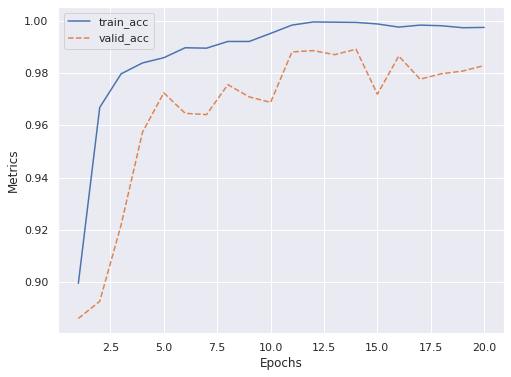

In [23]:
log.plot_epochs(['train_acc', 'valid_acc'])

In [24]:
classifier.load_state_dict(torch.load('/content/saved_model/resnet50_whole_classifier_weights.pth',map_location ='cpu'))


<All keys matched successfully>

In [27]:
tot=0
count=0
for i, data in enumerate(valid_dl):
        valid_loss, valid_acc = validate(data, classifier, loss_fn)
        tot+=valid_acc[0].item()
        count+=1

In [28]:
tot/count

0.9921875

In [27]:
torch.cuda.empty_cache()

In [30]:
import gc
# del variables
gc.collect()

6158

In [31]:
import shutil
shutil.copy('/content/saved_model/resnet50_whole_classifier_weights.pth','/content/drive/MyDrive/models/resnet50_whole_classifier_weights_final.pth')

'/content/drive/MyDrive/models/resnet50_whole_classifier_weights_final.pth'

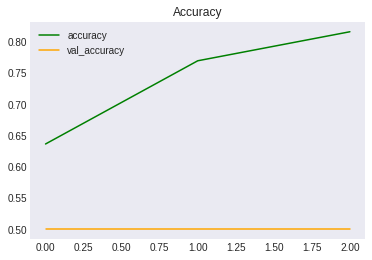

In [ ]:
plt.style.use("seaborn-dark")
plt.title("Accuracy")
plt.plot(History.history['accuracy'],label="accuracy",c='green')
plt.plot(History.history['val_accuracy'],label="val_accuracy",c='orange')
plt.legend()
plt.show()

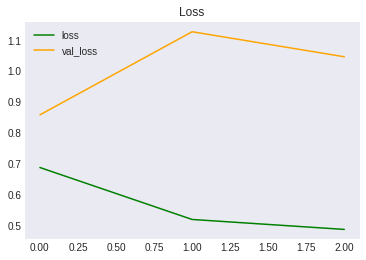

In [ ]:
plt.style.use("seaborn-dark")
plt.title("Loss")
plt.plot(History.history['loss'],label="loss",c='green')
plt.plot(History.history['val_loss'],label="val_loss",c='orange')
plt.legend()
plt.show()